# 3.01.2 First meteo data

* Functions which ar no longer part of this development step are exported to the music_generation.py file. The file is found at the en of the page.

In [76]:
from pyknon.genmidi import Midi
from pyknon.music import Rest, Note, NoteSeq
import music_generation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from datetime import date

## Transform Meteo data

In [77]:
def scale(a):    return (a-a.min())/(a.max()-a.min())
h24 = 6*24
h72 = 3*h24

def read_meteo_data(fName):
    colNames = ['Stao','time', 'Flash', 'p_QNH', 'T_2m', 'Precip', 'H_rel', 'V_wind']  
    df = pd.read_csv(fName,sep=';', skiprows=3, names=colNames, na_values='-')
    print(df.head())
    return df

fPath = '/mnt/daten/04_Schule/42_Kanti/Matrua/Music_generation/Organisation/MeteoSchweiz/Daten/'
fName = 'order_74678_data.txt'
dM = read_meteo_data(fPath+fName)

#---- Parameter bestimmen -----------
NT, MP = dM.shape
print('-----------------')
print('NT, MP', NT, MP)



  Stao          time  Flash  p_QNH  T_2m  Precip  H_rel  V_wind
0  KLO  201908280000      0  968.5  19.6     0.0   90.1     0.6
1  KLO  201908280010      0  968.5  19.3     0.0   93.0     0.6
2  KLO  201908280020      0  968.6  19.4     0.0   90.6     0.7
3  KLO  201908280030      0  968.7  19.6     0.0   90.3     0.7
4  KLO  201908280040      0  968.7  18.7     0.0   95.6     0.5
-----------------
NT, MP 2016 8


[-1 -2  0  2 -2 -3 -2 -1 -2 -1 -1  1  2  2  3  2 -1 -1  1 -1  0  0  1  1
 -2 -1  0  0 -1 -1 -2 -1  0  1  2  4  1  1  1  1  0  0  0  0 -1 -2 -3 -1
 -2 -1 -1 -1  0  0  1  3  4  2  1  1  1  0  0  0  0 -1 -2 -3 -2 -2 -1 -1
 -2  2  2  0  1  1  1  1  2  0  0  0 -1  0 -1 -1  2 -2  0 -2 -1 -1  1  1
  1  6  2  0  0  0  0  0  0 -1  0 -2 -3  0  1  0  0 -1 -1  2  2  1  2  1
  1  0  0  0  0  0  0  0  0 -2 -4 -5 -3  0  0  0  0  4  4  2  1]
141


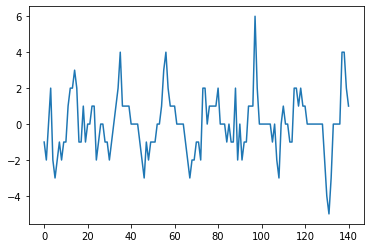

In [78]:
k=6
w = 7
Y = np.array(dM[dM.columns[k]])
Y24 = np.array(dM[dM.columns[k]].rolling(window=h24,center=True).mean())
Y72 = np.array(dM[dM.columns[k]].rolling(window=h72,center=True).mean())
Yw  = np.array(dM[dM.columns[k]].rolling(window=w,center=True).mean()) 
Yw= Yw[0:1000:w]
trans = np.diff(Yw)[1:]
trans = np.round(trans/4)
#trans = np.nancumsum(trans)
trans = trans.astype(int)
print(trans)

plt.plot(trans)
#plt.hist(trans,bins=50)

print(len(trans))


## Functions for Music generation

In [79]:
major = np.array([ 0, 2, 4, 5, 7, 9, 11])
minor = np.array([ 0, 2, 3, 5, 7, 8, 10])  
C7 = np.array([ 0, 4, 7, 10]) 
CM7 = np.array([ 0, 4, 7, 11])
Cm7 = np.array([ 0, 3, 7, 10])
Cm  = np.array([ 0, 3, 7])
C   = np.array([ 0, 4, 7])
bass= np.array([ 0])

## Tune T 

In [80]:
def meteo_melody(met_intvl, pattern, start_note, a_range, notenr, rythem):
    melody = np.zeros(notenr, dtype=int)
    cum_rythem = np.cumsum(rythem) *4
    cum_rythem = np.concatenate(([0],cum_rythem))[:-1] # add 0 at beginig remove last element
    scale_change = pattern[:,0]
    scale_nr =0
    scale = pattern[scale_nr,1]
    melody[0] = scale[i_last_note(start_note,scale)]
    cummelody = i_last_note(start_note,scale)+np.nancumsum(met_intvl)
    print(cummelody)
    
    for npn in range(1, notenr):  #npn: note per note (index)      
        scale_nr = np.ravel(np.argwhere(scale_change <= cum_rythem[npn-1])) [-1]     
        scale = pattern[scale_nr,1]
        inote_next = cummelody[npn-1]
        #print(inote_next,scale)
        
        '''
        accept = False    
        while not accept:       # aslong acept == False
            inote = i_last_note(melody[npn-1],scale)
            inote_next = inote + intvl_next(intvl, prob_intvl)         # add current not with Proposition
            accept_val = a_range[[melody[(npn-1)],scale[inote_next]]]  # get acceptance values
            accept = acceptance(accept_val[0],accept_val[1])
        '''

        melody[npn] = scale[inote_next]
    print(melody)
    return melody

In [81]:
def tune_T():
    tune_name = 'tune_T'  
    #np.random.seed(23)
    bar, bpb = 12, 4  # bar: Takt , bpb: beat per bar
    melody_len = bar * bpb


    #scales = [[1,CM7],[1,Cm7+9],[1,Cm7+2],[1,C7+7]] #rythem Change
    #scales = [[4,C7],[2,C7+5],[2,C7],[1,C7+7],[1,C7+5],[2,C7]] # Blues  
    scales = [[8,major]]
    pattern = pattern_gen(scales, melody_len)
    
    range_1 = liniar_range(44,51,70,76)
    rythem1, notenr_1 = ran_duration([1/8, 1/4,1/2], [1,4,1], melody_len)
    melody1 = meteo_melody(trans,pattern, 72, range_1, notenr_1, rythem1)
    volumes1 = ran_volume([0,120], [1,5], notenr_1 )
    notes1 = NoteSeq( [Note(no,octave=0, dur=du, volume=vo) for no,du,vo in zip(melody1,rythem1,volumes1)] )
       
    
    #plot_range([range_1],['range_1'],tune_name)
    instruments = [0]
    notes = [notes1]
    return notes, instruments,tune_name

__Instruments:__
Available are at lest the 128 General-Midi (GM) Instruments. Depending on the sound-fonts there is a bigger choise. A list of the GM instruments can be found here. https://jazz-soft.net/demo/GeneralMidi.html


## Generate Midi and Audio file

In [82]:
def gen_midi():
#     squezze into a MIDI framework
    notes, instruments, tune_name = tune_T() #  <--- select a tune  <<--     <<<<<<<<<--- select a tune -----
    nTracks = len(notes)
    
    m = Midi(number_tracks=nTracks, tempo=120, instrument=instruments)
    for iTrack in range(nTracks):
        m.seq_notes(notes[iTrack], track=iTrack)

    #--- write the MIDI file -----
    midi_file_name = tune_name +'.mid'   # set the name of the file
    m.write(midi_file_name)
    return midi_file_name

In [83]:
######---  Main  ---######
midi_file_name = gen_midi()

midi_play(midi_file_name)
midi_audio(midi_file_name)
midi_png(midi_file_name)

[41 39 39 41 39 36 34 33 31 30 29 30 32 34 37 39 38 37 38 37 37 37 38 39
 37 36 36 36 35 34 32 31 31 32 34 38 39 40 41 42 42 42 42 42 41 39 36 35
 33 32 31 30 30 30 31 34 38 40 41 42 43 43 43 43 43 42 40 37 35 33 32 31
 29 31 33 33 34 35 36 37 39 39 39 39 38 38 37 36 38 36 36 34 33 32 33 34
 35 41 43 43 43 43 43 43 43 42 42 40 37 37 38 38 38 37 36 38 40 41 43 44
 45 45 45 45 45 45 45 45 45 43 39 34 31 31 31 31 31 35 39 41 42]
[72 71 67 67 71 67 62 59 57 53 52 50 52 55 59 64 67 65 64 65 64 64 64 65
 67 64 62 62 62 60 59 55 53 53 55 59 65 67 69 71 72 72]


## External Music-Generation library
This library changes from version to version. New or changed code is first explaind above. 